#Hotdog or Not Hotdog?

Today, we'll be training a Convolutional Neural Net to classify images

The dataset we'll be using is at the link below. Be sure to click the "Download all" button. 
You may have log in to Kaggle. 

https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog/data

##Importing from Google Drive
This code block uses PyDrive to import a file from your Google Drive storage
onto Colab's local storage.

In [22]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/hotdog_data')
try:
  os.makedirs(local_download_path)
except: pass


############################################################################
####### Have to replace this with a file ID from your Google Drive   #######

file_id = '############################'

###################### End of replacement portion ##########################
############################################################################



# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters

file_lists = []
file_list = drive.ListFile({'q': "'{}' in parents".format(file_id)}).GetList()
for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)


title: hot-dog-not-hot-dog.zip, id: 1Fj8TfjXZAEEZiezObhzq0jzjhgveqZge
downloading to /content/hotdog_data/hot-dog-not-hot-dog.zip


In [0]:
##### We'll import all the Python modules we need

from matplotlib import pyplot as plt
import numpy as np
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
import glob
import random
import tensorflow as tf
import zipfile

In [0]:
#### Unzipping the file you've uploaded

zip_path = '{}/hot-dog-not-hot-dog.zip'.format(local_download_path)
zip_ref = zipfile.ZipFile('{}/hot-dog-not-hot-dog.zip'.format(local_download_path), 'r')
zip_ref.extractall(local_download_path)
zip_ref.close()
zip_ref = zipfile.ZipFile('{}/seefood.zip'.format(local_download_path), 'r')
zip_ref.extractall(local_download_path)
zip_ref.close()

##Getting the dataset ready
The data you got isn't ideally structured. There are around 500 images in the train data, and 500 images in the test data. Usually a distribution of 85% train and 15% test is adopted. Here, we've taken 900 images for the train data and 98 for the test. 

In [0]:
test_image_paths = [glob.glob('{}/test/hot_dog/*'.format(local_download_path)) , glob.glob('{}/test/not_hot_dog/*'.format(local_download_path))]
train_image_paths = [glob.glob('{}/train/hot_dog/*'.format(local_download_path)) , glob.glob('{}/train/not_hot_dog/*'.format(local_download_path))]
for i in range(201):
  train_image_paths[0].append(test_image_paths[0][i])
  train_image_paths[1].append(test_image_paths[1][i])
test_image_paths[0] = test_image_paths[0][201:]
test_image_paths[1] = test_image_paths[1][201:]

We now have a two lists, each with a number of paths to images. We need to extract the actual image data now. We'll use the "io" subpackage from the skimage module for that

In [0]:
# the 2 labels
one_hot_vectors = np.array([[(lambda i,j: int(i == j))(i,j)  for i in range(2)] for j in range(2)])

# function that takes a path to an image and extracts a 64 x 64 x 3 rescaled
# version of the image

def get_image(path):
  pic = io.imread(path)
  return resize(pic,(64,64))

# function that takes a list of paths ((train/test)_image_paths)
# and the number of images that are to be extracted (from each category
# of images)

def get_images(paths, max_imgs_per_type):
  images = []
  labels = []
  img_ctrs = [0,0]
  
  max_ind = max_imgs_per_type
  for i in range(2 * max_imgs_per_type):
    ind = random.randint(0,1)
    if(img_ctrs[ind] >= max_ind):
      ind = int(not ind)   
    image = get_image(paths[ind][img_ctrs[ind]])      
    img_ctrs[ind] += 1
    images.append(image)
    labels.append(one_hot_vectors[ind])
  return np.array(images),np.array(labels)
  

In [52]:
train_images,train_labels = get_images(train_image_paths, 450)
test_images, test_labels = get_images(test_image_paths, 49)

train_images_len = len(train_images)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[0 1]


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


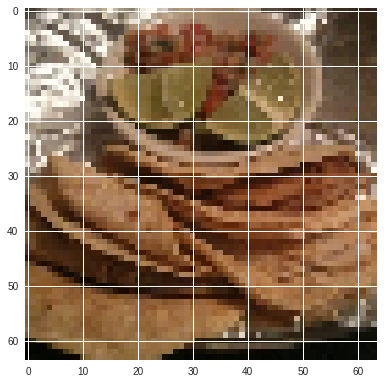

In [45]:
# visualizing what our data looks like is helpful
io.imshow(train_images[150])
print(train_labels[150])

In [0]:

def get_batch_and_labels(batch_size, starting_index, max_len):
  batch = []
  labels = []
  
  if starting_index + batch_size >= max_len:
    batch = train_images[starting_index:]
    labels = train_labels[starting_index:]
    batch = np.concatenate((batch,train_images[:batch_size + starting_index - max_len]))
    labels = np.concatenate((labels, train_labels[:batch_size + starting_index - max_len]))
  else:
    batch = train_images[starting_index:starting_index + batch_size]
    labels = train_labels[starting_index:starting_index + batch_size]
  return np.array(batch), np.array(labels)


##Our CNN model

In [0]:
n_epochs = 250
minibatch_size = 40
lr = 1e-4
keep = 0.5

In [0]:
# our input data
x = tf.placeholder(tf.float32, shape = [None, 64,64 , 3])

# our softmax predictions 
y_ = tf.placeholder(tf.float32, shape = [None, 2])

In [0]:
def weight_variable(shape):
    """Initializes weights randomly from a normal distribution
    Params: shape: list of dimensionality of the tensor to be initialized
    """
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """Initializes the bias term randomly from a normal distribution.
    Params: shape: list of dimensionality for the bias term.
    """
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


###Conv + Relu + Pool

In [86]:
W_conv1 = weight_variable([5, 5, 3, 16]) # 5 x 5 kernel (filter), across an image with 3 channels to 16 channels
b_conv1 = bias_variable([16])
h_conv1 = tf.nn.relu(tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1) # conv + relu
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='SAME') #max pool with 3x3 filter and stride 2
h_pool1

<tf.Tensor 'MaxPool_12:0' shape=(?, 32, 32, 16) dtype=float32>

In [76]:
# Try it yourself !

# We want a conv layer (followed by ReLu) with 5x5 filters 
# (we'll leave it to you to figure out the depth of the filters)
# We also want the output to have a depth of 32
# We want max pool filters of shape 3x3 that move with stride 2


##### Begin inserting code here #####
##### Four lines should suffice #####





##### End inserting code here #####


<tf.Tensor 'MaxPool_9:0' shape=(?, 16, 16, 32) dtype=float32>

In [77]:
# Try it yourself !

# We want a conv layer (followed by ReLu) with 3x3 filters
# (we'll leave it to you to figure out the depth of the filters)
# We also want the output to have a depth of 64
# We want max pool filters of shape 2x2 that move with stride 2


##### Begin inserting code here #####
##### Four lines should suffice #####





##### End inserting code here #####

<tf.Tensor 'MaxPool_10:0' shape=(?, 8, 8, 64) dtype=float32>

In [88]:
# Try it yourself !

# We want a conv layer (followed by ReLu) with 3x3 filters, but here
# we want the filters to move with stride 2 instead of the usual 1
# (we'll leave it to you to figure out the depth of the filters)
# We also want the output to have a depth of 64
# We DON'T want a max pool layer

# Make sure this code block runs without errors
# (Hint: call the output of this layer h_conv4, 
# this just makes things easier for us)


##### Begin inserting code here #####
##### Three lines should suffice #####




##### End inserting code here #####
h_conv4

<tf.Tensor 'Relu_20:0' shape=(?, 16, 16, 64) dtype=float32>

### FC + Dropout

In [0]:
# flattening h_conv4
h_conv_flat = tf.reshape(h_conv4, [-1, 4 * 4 * 64])

# Fully connected layer

W_fc1 = weight_variable([4 * 4 * 64, 512]) 
b_fc1 = bias_variable([512])
h_fc1 = tf.nn.relu(tf.matmul(h_conv_flat, W_fc1) + b_fc1)

# dropout layer
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [0]:
# Try it yourself !

# We want a FC layer that produces a vector of size 128

##### Begin inserting code here #####
##### Three lines should suffice #####




##### End inserting code here #####

# We want a dropout layer with the same keep probability as before

##### Begin inserting code here #####
##### One line should suffice #####


##### End inserting code here #####


In [0]:
# Try it yourself !

# This is our final FC layer 
# (we leave it to you to figure out what the size of the output vector should be)

# This block should run without errors
# (Hint: call the output of this layer y_out,
# this just makes things easier for us)

##### Begin inserting code here #####
##### Three lines should suffice #####




##### End inserting code here #####
y_out

###Loss

In [0]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_out, labels = y_)
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_, axis = 1), tf.argmax(y_out, axis = 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()

###Training

In [96]:
with tf.Session() as sess:
  sess.run(init)
  for i in range(n_epochs):
    training_inputs, training_labels = get_batch_and_labels(minibatch_size, i*minibatch_size, train_images_len)    
    if i % 1 == 0:
      print("epoch:{}".format(i))
      train_acc = accuracy.eval(feed_dict = {x: training_inputs, y_: training_labels, keep_prob : 1.0})
      print("training accuracy: {}".format(train_acc))
    
    ##### sess.run #####
    #### Start code insertion (careful with indentation) ####
    
    
    ################## End code insertion ###################
  
  #### test_acc ####
  #### Start code insertion (careful with indentation) ####
  
  
  ################ End code insertion #####################
  print("test accuracy: {}".format(test_acc))

epoch:0
training accuracy: 0.44999998807907104
epoch:1
training accuracy: 0.6000000238418579
epoch:2
training accuracy: 0.5
epoch:3
training accuracy: 0.4749999940395355
epoch:4
training accuracy: 0.574999988079071
epoch:5
training accuracy: 0.574999988079071
epoch:6
training accuracy: 0.699999988079071
epoch:7
training accuracy: 0.42500001192092896
epoch:8
training accuracy: 0.42500001192092896
epoch:9
training accuracy: 0.5249999761581421
epoch:10
training accuracy: 0.4749999940395355
epoch:11
training accuracy: 0.574999988079071
epoch:12
training accuracy: 0.32499998807907104
epoch:13
training accuracy: 0.5249999761581421
epoch:14
training accuracy: 0.699999988079071
epoch:15
training accuracy: 0.4000000059604645
epoch:16
training accuracy: 0.6499999761581421
epoch:17
training accuracy: 0.574999988079071
epoch:18
training accuracy: 0.5
epoch:19
training accuracy: 0.6000000238418579
epoch:20
training accuracy: 0.550000011920929
epoch:21
training accuracy: 0.3499999940395355
epoch:22


training accuracy: 0.6822222471237183
epoch:73
training accuracy: 0.6899999976158142
epoch:74
training accuracy: 0.7044444680213928
epoch:75
training accuracy: 0.7099999785423279
epoch:76
training accuracy: 0.7133333086967468
epoch:77
training accuracy: 0.7177777886390686
epoch:78
training accuracy: 0.7177777886390686
epoch:79
training accuracy: 0.7233333587646484
epoch:80
training accuracy: 0.7277777791023254
epoch:81
training accuracy: 0.7344444394111633
epoch:82
training accuracy: 0.7377777695655823
epoch:83
training accuracy: 0.742222249507904
epoch:84
training accuracy: 0.7388888597488403
epoch:85
training accuracy: 0.7411110997200012
epoch:86
training accuracy: 0.746666669845581
epoch:87
training accuracy: 0.7522222399711609
epoch:88
training accuracy: 0.7599999904632568
epoch:89
training accuracy: 0.7588889002799988
epoch:90
training accuracy: 0.754444420337677
epoch:91
training accuracy: 0.7588889002799988
epoch:92
training accuracy: 0.7655555605888367
epoch:93
training accurac

training accuracy: 0.8744444251060486
epoch:137
training accuracy: 0.8822222352027893
epoch:138
training accuracy: 0.897777795791626
epoch:139
training accuracy: 0.9044444561004639
epoch:140
training accuracy: 0.9066666960716248
epoch:141
training accuracy: 0.903333306312561
epoch:142
training accuracy: 0.8877778053283691
epoch:143
training accuracy: 0.8866666555404663
epoch:144
training accuracy: 0.9011111259460449
epoch:145
training accuracy: 0.9144444465637207
epoch:146
training accuracy: 0.9200000166893005
epoch:147
training accuracy: 0.9200000166893005
epoch:148
training accuracy: 0.9188888669013977
epoch:149
training accuracy: 0.9166666865348816
epoch:150
training accuracy: 0.903333306312561
epoch:151
training accuracy: 0.8955555558204651
epoch:152
training accuracy: 0.9011111259460449
epoch:153
training accuracy: 0.9200000166893005
epoch:154
training accuracy: 0.9233333468437195
epoch:155
training accuracy: 0.9277777671813965
epoch:156
training accuracy: 0.9333333373069763
epoch

training accuracy: 0.9788888692855835
epoch:201
training accuracy: 0.9822221994400024
epoch:202
training accuracy: 0.9822221994400024
epoch:203
training accuracy: 0.9833333492279053
epoch:204
training accuracy: 0.9833333492279053
epoch:205
training accuracy: 0.9833333492279053
epoch:206
training accuracy: 0.9833333492279053
epoch:207
training accuracy: 0.9855555295944214
epoch:208
training accuracy: 0.9855555295944214
epoch:209
training accuracy: 0.9855555295944214
epoch:210
training accuracy: 0.9855555295944214
epoch:211
training accuracy: 0.9866666793823242
epoch:212
training accuracy: 0.9866666793823242
epoch:213
training accuracy: 0.9855555295944214
epoch:214
training accuracy: 0.9855555295944214
epoch:215
training accuracy: 0.9877777695655823
epoch:216
training accuracy: 0.9844444394111633
epoch:217
training accuracy: 0.9844444394111633
epoch:218
training accuracy: 0.9866666793823242
epoch:219
training accuracy: 0.9877777695655823
epoch:220
training accuracy: 0.9900000095367432
ep

##Results

You'll see our model achieved a good training accuracy but a pretty bad test accuracy.

Why is our model doing badly with test data?

What are the remedies ?


##More resources:

http://cs231n.github.io/convolutional-networks/
